In [1]:
from src.operators.radontr import Radontr
from src.operators.operator import Operator
from src.operators.gradient import Gradient
from src.recon.pwls import PWLS
from src.recon.chambolle_pock import ChambollePock
from src.recon.admm import ADMM
from src.utils.dataloader import ct_test_dataloader, unstandardization
from src.models.unet_diffusion import UNet
from src.losses.data_fidelity import DataFidelity
# from src.recon.dps import DeepPosteriorSampling

from PIL import Image
import torch
import numpy as np
import torch_radon as tr
import matplotlib.pyplot as plt


FileNotFoundError: [Errno 2] No such file or directory: './data/train_slices'

In [ ]:




device = 'cuda'

# define projector settings
n_rays = int(np.round(np.sqrt(2)*128))
height, width = 128, 128
n_angles = 52
volume = tr.Volume2D()
volume.set_size(height=height, width=width)
angles = torch.linspace(0, 2 * torch.pi * ((n_angles - 1))/n_angles, n_angles, device=device)

# define projector
radon = Radontr(n_rays=n_rays,
              angles=angles,
              volume=volume)  # Radon class

# load image
x_true = next(iter(ct_test_dataloader))
# unstandardization, because dataloader throw standardized ct scans
x_true = unstandardization(x_true)

plt.imshow(x_true.squeeze(), cmap='gray')
plt.show() # to avoid overprinting images

# The following is needed to create a Torch object. This requires to add 2 additional dimensions, 1 for batch size, 1 for the number of channels (n,c,d,h,w) (d for depth (not used here in 2D))
x_true = x_true.to(device)   # 0 is the index of the dimension to be added


# generate noisy sinogram
I = 3e5
# EPS = 1e-10
sino = radon.transform(x_true)
yi = torch.poisson(I*torch.exp(-sino))
b = torch.zeros_like(yi, device=device)
# b = torch.log(I/ (yi))
b[yi != 0] = torch.log(I/ (yi[yi != 0])) ;


# print(yi.min())

# shared params
x0 = torch.zeros_like(x_true, device=device)

b_im = b.squeeze().cpu().numpy()
plt.imshow(b_im)
# to avoid overprinting images
plt.show() # to avoid overprinting images
n_iter = 300
n_inner_iter = 100
weights = yi
weights[yi == 0] = 0

ModuleNotFoundError: No module named 'torchvision'

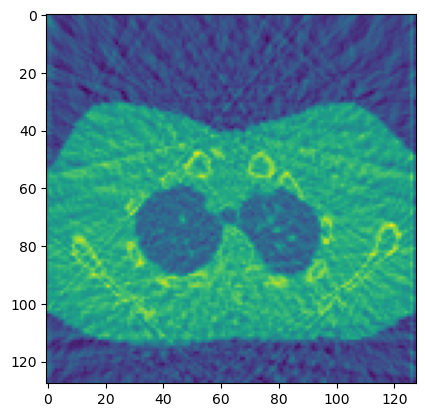

In [3]:
#############################################################################################################################
#                                                           FBP                                                             #
#############################################################################################################################


x_fbp = radon.fbp(b)
plt.show() # to avoid overprinting images
plt.imshow(x_fbp.cpu().squeeze())
plt.imsave('./data/fbp.png', x_fbp.cpu().squeeze(), cmap='gray')

In [4]:
#############################################################################################################################
#                                                           PWLS                                                            #
#############################################################################################################################

sparsifier = Gradient(weight = 'sqrt')
recon = PWLS(systmatrix=radon, sparsifier=sparsifier)

beta = 1e5

x = recon.solve(x0,
                b,
                beta,
                n_iter,
                weights)

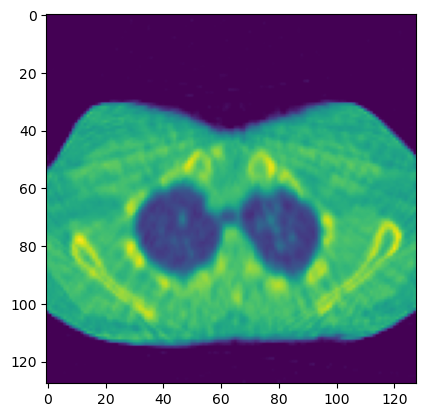

In [5]:
plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())

In [6]:
#############################################################################################################################
#                                                           ADMM                                                            #
#############################################################################################################################

sparsifier = Gradient(weight = 'standard')
recon = ADMM(systmatrix=radon, sparsifier=sparsifier)

beta = 3e2
rho = 5000

x = recon.solve(x0,
                 b,
                 beta,
                 rho,
                 n_iter,
                 n_inner_iter,
                 weights)

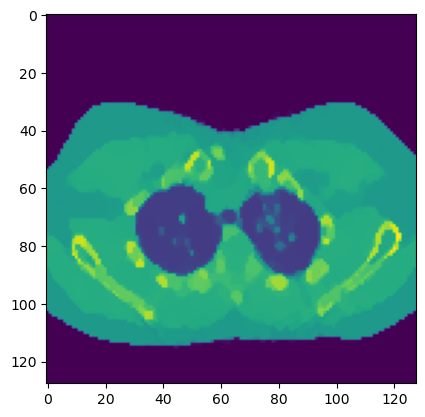

In [7]:
plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())

In [8]:
#############################################################################################################################
#                                                      Chambolle Pock                                                       #
#############################################################################################################################




sparsifier = Gradient(weight = 'standard')
recon = ChambollePock(systmatrix=radon, sparsifier=sparsifier)

beta = 3e2
theta = 1
L = sparsifier.norm(height, width)
sigma = 0.99 * (1e8 / (np.sqrt(1e8 * 1) * L))
tau = 0.99 * (1 / (np.sqrt(1e8 * 1) * L))

x = recon.solve( x0,
                    b,
                    beta,
                    tau,
                    sigma,
                    theta,
                    n_iter,
                    n_inner_iter,
                    weights)

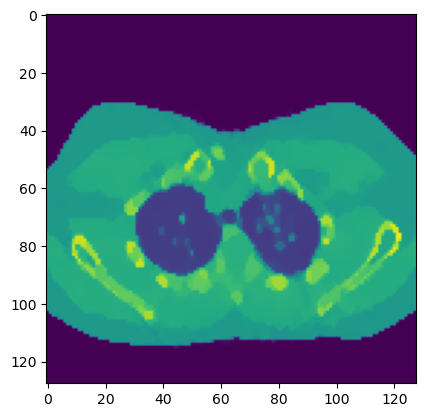

In [9]:
plt.show() # to avoid overprinting images
plt.imshow(x.cpu().squeeze())

In [ ]:
#############################################################################################################################
#                                                     DPS                                                                   #
#############################################################################################################################

# load pretrained models 
weights_path = './weights/wavelet128x128x128_standardized_diverse_model_epoch_199.pth'
model = model = UNet(in_chan=1,
             out_chan=1,
             T=1000,
             ch=128,
             ch_mult=[1, 2, 2, 2],
             attn=[1],
             num_res_blocks=2,
             dropout=0.1)
model.load_state_dict(torch.load(weights_path))
model.to(device)

# instantiate data fidelity term
data_fidelity = DataFidelity(forward_operator=radon)

# instanciate dps
dps = DeepPosteriorSampling(model=model,
                            data_fidelity=data_fidelity,
                            device=device)

# sampling
lam = 1

xT = torch.randn((1, 1, 128, 128)).to(device)
x0 = dps.inference(xT=xT, 
                    y=b,
                    weights=yi,
                    lam=lam)

/tmp/ipykernel_746187/4269819828.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))
133it [00:14,  9.03it/s]

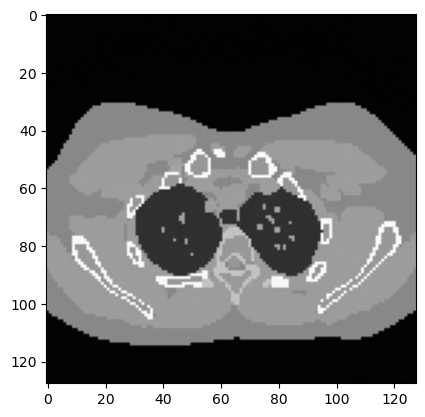

In [ ]:
plt.imshow(x0.cpu().squeeze())
plt.show() # to avoid overprinting images

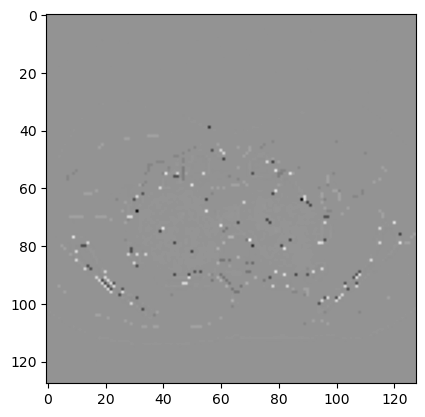

In [ ]:
# Display difference with ground truth
plt.imshow((x0 - x_true).cpu().squeeze(),cmap='gray')
plt.show() # to avoid overprinting images
